# 3.3 Exploring CRSP Data with Python

This script demonstrates how to explore and analyze CRSP daily stock data using various Python plotting libraries.

## Overview
We'll analyze CRSP daily stock data for selected stocks (AAPL, JNJ, TSLA) and compare their performance against the S&P 500 index. The analysis includes:
- Cumulative returns comparison
- Dividend analysis
- Rolling volatility analysis
- Multiple plotting approaches (Matplotlib, Seaborn, Plotly)

## Data Source
- CRSP Daily Stock File v2 (DSF) via WRDS
- Filtered for common stock universe with proper exchange and trading filters
- Date range: 2019-2025

In [1]:
import pandas as pd
import numpy as np
import wrds
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta

import config

DATA_DIR = config.DATA_DIR
WRDS_USERNAME = config.WRDS_USERNAME

db = wrds.Connection(wrds_username=WRDS_USERNAME)

Loading library list...


Done


## Understanding CRSP Data Structure

To find the right table, we use a combination of the web query interface and the SAS Studio explorer.
The web query interface is available at:
https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/stock-version-2/daily-stock-file/

Note: Web queries often use merges of tables from many different sources. The results of these merges are not usually available through the Python API interface. Often, you'll have to merge the tables yourself.

However, in this case, we can use the SAS Studio explorer to find the right table. Lucky for us, the data in the web query is available in a pre-merged table available through the Python API.

In [2]:
# First, let's look at the standard daily stock file (DSF) from the CIZ format
dsf = db.get_table(library="crsp", table="dsf_v2", obs=10)
dsf.head()

,permno,hdrcusip,permco,siccd,nasdissuno,yyyymmdd,sharetype,securitytype,securitysubtype,usincflg,...,dlyopen,dlynumtrd,dlymmcnt,dlyprcvol,dlycumfacpr,dlycumfacshr,cusip,ticker,exchangetier,shrout
0,10000,68391610,7952,3990,10396,19860107,NS,EQTY,COM,Y,...,<NA>,<NA>,9,2562.5,1.0,1.0,68391610,OMFGA,SC1,3680
1,10000,68391610,7952,3990,10396,19860108,NS,EQTY,COM,Y,...,<NA>,<NA>,9,32000.0,1.0,1.0,68391610,OMFGA,SC1,3680
2,10000,68391610,7952,3990,10396,19860109,NS,EQTY,COM,Y,...,<NA>,<NA>,9,3500.0,1.0,1.0,68391610,OMFGA,SC1,3680
3,10000,68391610,7952,3990,10396,19860110,NS,EQTY,COM,Y,...,<NA>,<NA>,10,21250.0,1.0,1.0,68391610,OMFGA,SC1,3680
4,10000,68391610,7952,3990,10396,19860113,NS,EQTY,COM,Y,...,<NA>,<NA>,10,14306.3,1.0,1.0,68391610,OMFGA,SC1,3680


In [3]:
dsf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   permno            10 non-null     Int64  
 1   hdrcusip          10 non-null     string 
 2   permco            10 non-null     Int64  
 3   siccd             10 non-null     Int64  
 4   nasdissuno        10 non-null     Int64  
 5   yyyymmdd          10 non-null     Int64  
 6   sharetype         10 non-null     string 
 7   securitytype      10 non-null     string 
 8   securitysubtype   10 non-null     string 
 9   usincflg          10 non-null     string 
 10  issuertype        10 non-null     string 
 11  primaryexch       10 non-null     string 
 12  conditionaltype   10 non-null     string 
 13  tradingstatusflg  10 non-null     string 
 14  dlycaldt          10 non-null     string 
 15  dlydelflg         10 non-null     string 
 16  dlyprc            10 non-null     Float64
 17  

## Finding the Pre-merged Table

Now, let's find the pre-merged table that contains the data we want.
Notice that it corresponds to the web query we used above.

In [4]:
df = db.get_table(library="crsp", table="wrds_dsfv2_query", obs=10)
df.head()

,permno,secinfostartdt,secinfoenddt,securitybegdt,securityenddt,securityhdrflg,hdrcusip,hdrcusip9,cusip,cusip9,...,disrecorddt,dispaydt,dispermno,dispermco,disamountsourcetype,vwretd,vwretx,ewretd,ewretx,sprtrn
0,10000,1986-01-07,1986-12-03,1986-01-07,1987-06-11,N,68391610,683916100,68391610,683916100,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.013809,0.0138,0.011061,0.011046,0.014954
1,10000,1986-01-07,1986-12-03,1986-01-07,1987-06-11,N,68391610,683916100,68391610,683916100,...,<NA>,<NA>,<NA>,<NA>,<NA>,-0.020744,-0.02075,-0.005117,-0.005135,-0.027269
2,10000,1986-01-07,1986-12-03,1986-01-07,1987-06-11,N,68391610,683916100,68391610,683916100,...,<NA>,<NA>,<NA>,<NA>,<NA>,-0.011219,-0.011315,-0.011588,-0.01166,-0.008944
3,10000,1986-01-07,1986-12-03,1986-01-07,1987-06-11,N,68391610,683916100,68391610,683916100,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.000083,0.000047,0.003651,0.003632,-0.000728
4,10000,1986-01-07,1986-12-03,1986-01-07,1987-06-11,N,68391610,683916100,68391610,683916100,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.00275,0.00268,0.002433,0.002369,0.00369


Note: We actually just made a mistake above. For some reason, we aren't allowed to access this via "crspa", but we are via "crsp".

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 98 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   permno               10 non-null     Int64  
 1   secinfostartdt       10 non-null     string 
 2   secinfoenddt         10 non-null     string 
 3   securitybegdt        10 non-null     string 
 4   securityenddt        10 non-null     string 
 5   securityhdrflg       10 non-null     string 
 6   hdrcusip             10 non-null     string 
 7   hdrcusip9            10 non-null     string 
 8   cusip                10 non-null     string 
 9   cusip9               10 non-null     string 
 10  primaryexch          10 non-null     string 
 11  conditionaltype      10 non-null     string 
 12  exchangetier         10 non-null     string 
 13  tradingstatusflg     10 non-null     string 
 14  securitynm           10 non-null     string 
 15  shareclass           10 non-null     string

Notice that this now matches the web query variables list.

## Defining the Data Query

Now, let's explore some of the columns. But first, we need to download more data.

In [6]:
query = """
SELECT 
    permno, 
    permco, 
    dlycaldt, 
    issuertype, 
    securitytype, 
    securitysubtype, 
    sharetype, 
    usincflg, 
    primaryexch, 
    conditionaltype, 
    tradingstatusflg,
    dlyret, 
    dlyretx, 
    dlyreti,
    dlyorddivamt,
    dlynonorddivamt,
    shrout, 
    dlyprc,
    ticker,
    securitynm,
    sprtrn,
    vwretd
FROM 
    crsp.wrds_dsfv2_query
WHERE 
    dlycaldt between '01/01/2019' and '01/01/2025' AND
    sharetype = 'NS' AND
    securitytype = 'EQTY' AND
    securitysubtype = 'COM' AND
    usincflg = 'Y' AND
    issuertype IN ('ACOR', 'CORP') AND
    primaryexch IN ('N', 'A', 'Q') AND
    conditionaltype = 'RW' AND
    tradingstatusflg = 'A'
"""

In [7]:
def pull_crsp_sample(data_dir=DATA_DIR):
    """
    Pull CRSP daily stock data with comprehensive filtering for common stock universe.
    
    This function implements the equivalent of legacy CRSP filters:
    - shrcd = 10 or 11 (common stock)
    - exchcd = 1, 2, or 3 (NYSE, AMEX, NASDAQ)
    
    Filters applied:
    1. Date range: 2019-2025
    2. Common stock universe:
       - sharetype = 'NS' (New Shares)
       - securitytype = 'EQTY' (Equity)
       - securitysubtype = 'COM' (Common Stock)
       - usincflg = 'Y' (US Incorporated)
       - issuertype IN ('ACOR', 'CORP') (Accordion or Corporate)
    3. Exchange and trading filters:
       - primaryexch IN ('N', 'A', 'Q') (NYSE, AMEX, NASDAQ)
       - conditionaltype = 'RW' (Regular Way trading)
       - tradingstatusflg = 'A' (Active trading status)
    
    Caching:
    - Data is cached locally as a parquet file to avoid repeated WRDS queries
    - If cached data exists, it loads from disk instead of querying WRDS
    - If no cache exists, queries WRDS and saves the result for future use
    
    Args:
        data_dir: Directory to store/load cached data
        
    Returns:
        DataFrame: Filtered CRSP daily stock data
    """
    data_path = data_dir / "crsp_dsf_v2_example.parquet"
    if data_path.exists():
        df = pd.read_parquet(data_path)
    else:
        df = db.raw_sql(query, date_cols=["dlycaldt"])
        df.to_parquet(data_path)
    return df

In [8]:
df = pull_crsp_sample()
df.head()

,permno,permco,dlycaldt,issuertype,securitytype,securitysubtype,sharetype,usincflg,primaryexch,conditionaltype,...,dlyretx,dlyreti,dlyorddivamt,dlynonorddivamt,shrout,dlyprc,ticker,securitynm,sprtrn,vwretd
0,10026,7976,2019-01-02,CORP,EQTY,COM,NS,Y,Q,RW,...,-0.024829,0.0,0.0,0.0,18774,141.0,JJSF,J & J SNACK FOODS CORP; COM NONE; CONS,0.001269,0.001796
1,10028,7978,2019-01-02,CORP,EQTY,COM,NS,Y,A,RW,...,-0.043488,0.0,0.0,0.0,26924,0.4399,DGSE,D G S E COMPANIES INC; COM NONE; CONS,0.001269,0.001796
2,10032,7980,2019-01-02,CORP,EQTY,COM,NS,Y,Q,RW,...,0.012921,0.0,0.0,0.0,30992,51.74,PLXS,PLEXUS CORP; COM NONE; CONS,0.001269,0.001796
3,10044,7992,2019-01-02,CORP,EQTY,COM,NS,Y,Q,RW,...,0.012887,0.0,0.0,0.0,5949,8.63,RMCF,ROCKY MOUNTAIN CHOC FAC INC NEW; COM NONE; CONS,0.001269,0.001796
4,10051,7999,2019-01-02,CORP,EQTY,COM,NS,Y,N,RW,...,-0.003694,0.0,0.0,0.0,36848,18.88,HNGR,HANGER INC; COM NONE; CONS,0.001269,0.001796


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5981476 entries, 0 to 481475
Data columns (total 22 columns):
 #   Column            Dtype         
---  ------            -----         
 0   permno            Int64         
 1   permco            Int64         
 2   dlycaldt          datetime64[ns]
 3   issuertype        string        
 4   securitytype      string        
 5   securitysubtype   string        
 6   sharetype         string        
 7   usincflg          string        
 8   primaryexch       string        
 9   conditionaltype   string        
 10  tradingstatusflg  string        
 11  dlyret            Float64       
 12  dlyretx           Float64       
 13  dlyreti           Float64       
 14  dlyorddivamt      Float64       
 15  dlynonorddivamt   Float64       
 16  shrout            Int64         
 17  dlyprc            Float64       
 18  ticker            string        
 19  securitynm        string        
 20  sprtrn            Float64       
 21  vwretd        

## Data Summary and Exploration

Let's look at some summary statistics to understand our dataset.

In [10]:
# Let's look at some summary statistics
print("\n=== Data Summary ===")
print(f"Date range: {df['dlycaldt'].min()} to {df['dlycaldt'].max()}")
print(f"Number of unique stocks: {df['permno'].nunique()}")
print(f"Total observations: {len(df)}")


=== Data Summary ===
Date range: 2019-01-02 00:00:00 to 2024-12-31 00:00:00
Number of unique stocks: 5488
Total observations: 5981476


## Identifying Well-Known Stocks

We'll look for stocks with recognizable tickers and good data coverage for our analysis.

In [11]:
# Let's identify some well-known stocks for analysis
# We'll look for stocks with recognizable tickers and good data coverage
stock_summary = df.groupby(['permno', 'ticker', 'securitynm']).agg({
    'dlycaldt': ['count', 'min', 'max'],
    'dlyret': 'count',
    'dlyorddivamt': lambda x: (x > 0).sum()
}).round(2)

stock_summary.columns = ['obs_count', 'start_date', 'end_date', 'return_obs', 'dividend_days']
stock_summary = stock_summary.reset_index()

# Filter for stocks with good data coverage and recognizable names
good_stocks = stock_summary[
    (stock_summary['obs_count'] > 500) &  # At least 500 observations
    (stock_summary['ticker'].notna()) &   # Has a ticker
    (stock_summary['ticker'] != '')       # Ticker is not empty
].sort_values('obs_count', ascending=False)

print("\n=== Top Stocks by Data Coverage ===")
good_stocks.head(20)


=== Top Stocks by Data Coverage ===


,permno,ticker,securitynm,obs_count,start_date,end_date,return_obs,dividend_days
4193,32651,HL,HECLA MINING CO; COM NONE; CONS,1526,2019-01-02,2024-12-31,1526,40.0
1624,17743,WRB,BERKLEY W R CORP; COM NONE; CONS,1520,2019-01-02,2024-12-31,1520,35.0
1240,16437,CWH,CAMPING WORLD HOLDINGS INC; COM A; CONS,1520,2019-01-02,2024-12-31,1520,34.0
1004,15540,RILY,B RILEY FINANCIAL INC; COM NONE; CONS,1519,2019-01-02,2024-12-31,1519,31.0
401,13641,FANG,DIAMONDBACK ENERGY INC; COM NONE; CONS,1519,2019-01-02,2024-12-31,1519,33.0
4195,32707,HP,HELMERICH & PAYNE INC; COM NONE; CONS,1518,2019-01-02,2024-12-31,1518,32.0
4337,47626,CNA,C N A FINANCIAL CORP; COM NONE; CONS,1516,2019-01-02,2024-12-31,1516,30.0
4697,76266,PRK,PARK NATIONAL CORP; COM NONE; CONS,1516,2019-01-02,2024-12-31,1516,30.0
4863,78211,UVE,UNIVERSAL INSURANCE HOLDINGS INC; COM NONE; CONS,1516,2019-01-02,2024-12-31,1516,30.0
70,10901,ITIC,INVESTORS TITLE CO; COM NONE; CONS,1516,2019-01-02,2024-12-31,1516,30.0


## Selecting Stocks for Analysis

Let's select three stocks for analysis:
1. A dividend-paying stock (likely a utility or financial)
2. A growth stock that pays no dividends (likely tech)
3. A stock in between

In [12]:
# Let's look for some specific well-known stocks
target_tickers = ['AAPL', 'MSFT', 'JNJ', 'PG', 'KO', 'XOM', 'JPM', 'WMT', 'NVDA', 'TSLA']
available_stocks = good_stocks[good_stocks['ticker'].isin(target_tickers)]

print("\n=== Available Target Stocks ===")
available_stocks


=== Available Target Stocks ===


,permno,ticker,securitynm,obs_count,start_date,end_date,return_obs,dividend_days
3375,22111,JNJ,JOHNSON & JOHNSON; COM NONE; CONS,1510,2019-01-02,2024-12-31,1510,24.0
4430,55976,WMT,WALMART INC; COM NONE; CONS,1510,2019-01-02,2024-12-31,1510,24.0
4344,47896,JPM,JPMORGAN CHASE & CO; COM NONE; CONS,1510,2019-01-02,2024-12-31,1510,24.0
5516,86580,NVDA,NVIDIA CORP; COM NONE; CONS,1510,2019-01-02,2024-12-31,1510,24.0
6450,93436,TSLA,TESLA INC; COM NONE; CONS,1510,2019-01-02,2024-12-31,1510,0.0
141,11850,XOM,EXXON MOBIL CORP; COM NONE; CONS,1510,2019-01-02,2024-12-31,1510,24.0
682,14593,AAPL,APPLE INC; COM NONE; CONS,1510,2019-01-02,2024-12-31,1510,24.0
1792,18163,PG,PROCTER & GAMBLE CO; COM NONE; CONS,1510,2019-01-02,2024-12-31,1510,24.0
91,11308,KO,COCA COLA CO; COM NONE; CONS,1510,2019-01-02,2024-12-31,1510,24.0
8,10107,MSFT,MICROSOFT CORP; COM NONE; CONS,1510,2019-01-02,2024-12-31,1510,24.0


In [13]:
# Select three stocks for analysis
selected_stocks = ['AAPL', 'JNJ', 'TSLA']  # Apple (tech, some dividends), J&J (dividend payer), Tesla (no dividends)

# Filter data for selected stocks and market
selected_data = df[df['ticker'].isin(selected_stocks)].copy()
market_data = df[['dlycaldt', 'sprtrn', 'vwretd']].drop_duplicates().copy()

## Data Quality Check

Let's verify our data quality and check for any duplicate entries.

In [14]:
# Debug: Check for duplicate dates in selected data
print(f"\n=== Data Quality Check ===")
print(f"Selected stocks data shape: {selected_data.shape}")
print(f"Duplicate ticker-date combinations: {selected_data.duplicated(subset=['ticker', 'dlycaldt']).sum()}")
print(f"Market data shape: {market_data.shape}")
print(f"Duplicate dates in market data: {market_data.duplicated(subset=['dlycaldt']).sum()}")

# Show sample of selected data
print(f"\nSample of selected data:")
print(selected_data[['ticker', 'dlycaldt', 'dlyret']].head(10))


=== Data Quality Check ===
Selected stocks data shape: (4530, 22)
Duplicate ticker-date combinations: 0
Market data shape: (1510, 3)
Duplicate dates in market data: 0

Sample of selected data:
      ticker   dlycaldt    dlyret
568     AAPL 2019-01-02  0.001141
1537     JNJ 2019-01-02 -0.010074
3592    TSLA 2019-01-02 -0.068149
4161    AAPL 2019-01-03 -0.099607
5129     JNJ 2019-01-03  -0.01589
7184    TSLA 2019-01-03 -0.031472
7754    AAPL 2019-01-04  0.042689
8721     JNJ 2019-01-04  0.016783
10776   TSLA 2019-01-04  0.057697
11345   AAPL 2019-01-07 -0.002226


## Calculating Cumulative Returns

Now let's calculate cumulative returns for our selected stocks to analyze their performance over time.

In [15]:
def calculate_cumulative_returns(data, return_col='dlyret'):
    """Calculate cumulative returns for each stock"""
    data = data.copy()
    data = data.sort_values(['ticker', 'dlycaldt'])
    
    # Handle potential duplicate dates by taking the last observation for each ticker-date combination
    data = data.drop_duplicates(subset=['ticker', 'dlycaldt'], keep='last')
    
    # Calculate cumulative returns (1 + return) for each stock using a safer approach
    data['cumret'] = 1.0  # Initialize with 1
    
    for ticker in data['ticker'].unique():
        mask = data['ticker'] == ticker
        returns = data.loc[mask, return_col].fillna(0)
        cumulative = (1 + returns).cumprod()
        data.loc[mask, 'cumret'] = cumulative
    
    return data

In [16]:
# Calculate cumulative returns
stock_cumret = calculate_cumulative_returns(selected_data)
market_cumret = market_data.copy()
market_cumret['cumret'] = (1 + market_cumret['sprtrn']).cumprod()

## Plot 1: Matplotlib - Cumulative Returns Comparison

Let's start with a traditional matplotlib plot to visualize the cumulative returns.

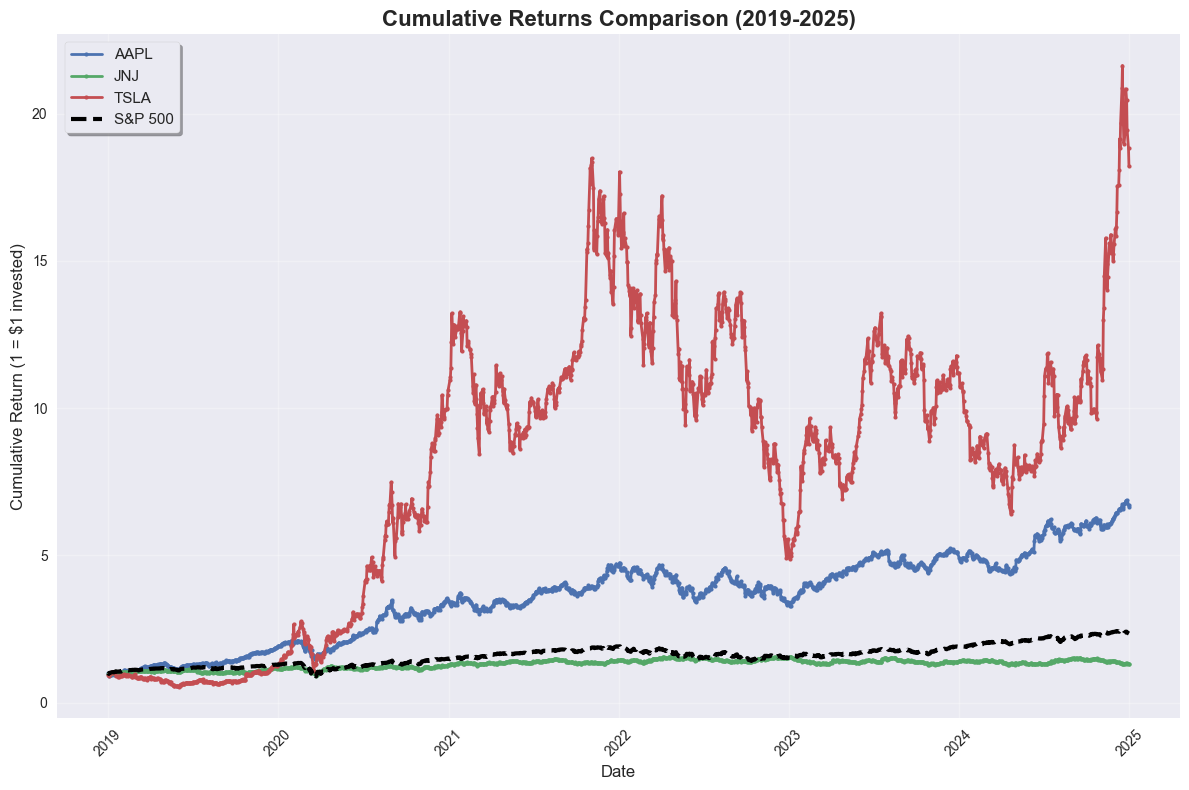

In [17]:
# Plot 1: Matplotlib - Cumulative Returns Comparison
plt.figure(figsize=(12, 8))
plt.style.use('seaborn-v0_8')

for ticker in selected_stocks:
    ticker_data = stock_cumret[stock_cumret['ticker'] == ticker]
    plt.plot(ticker_data['dlycaldt'], ticker_data['cumret'], 
             label=ticker, linewidth=2, marker='o', markersize=3)

# Add market portfolio
plt.plot(market_cumret['dlycaldt'], market_cumret['cumret'], 
         label='S&P 500', linewidth=3, color='black', linestyle='--')

plt.title('Cumulative Returns Comparison (2019-2025)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (1 = $1 invested)', fontsize=12)
plt.legend(fontsize=11, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Plot 2: Seaborn - Cumulative Returns with Better Styling

Now let's use Seaborn for enhanced styling and aesthetics.

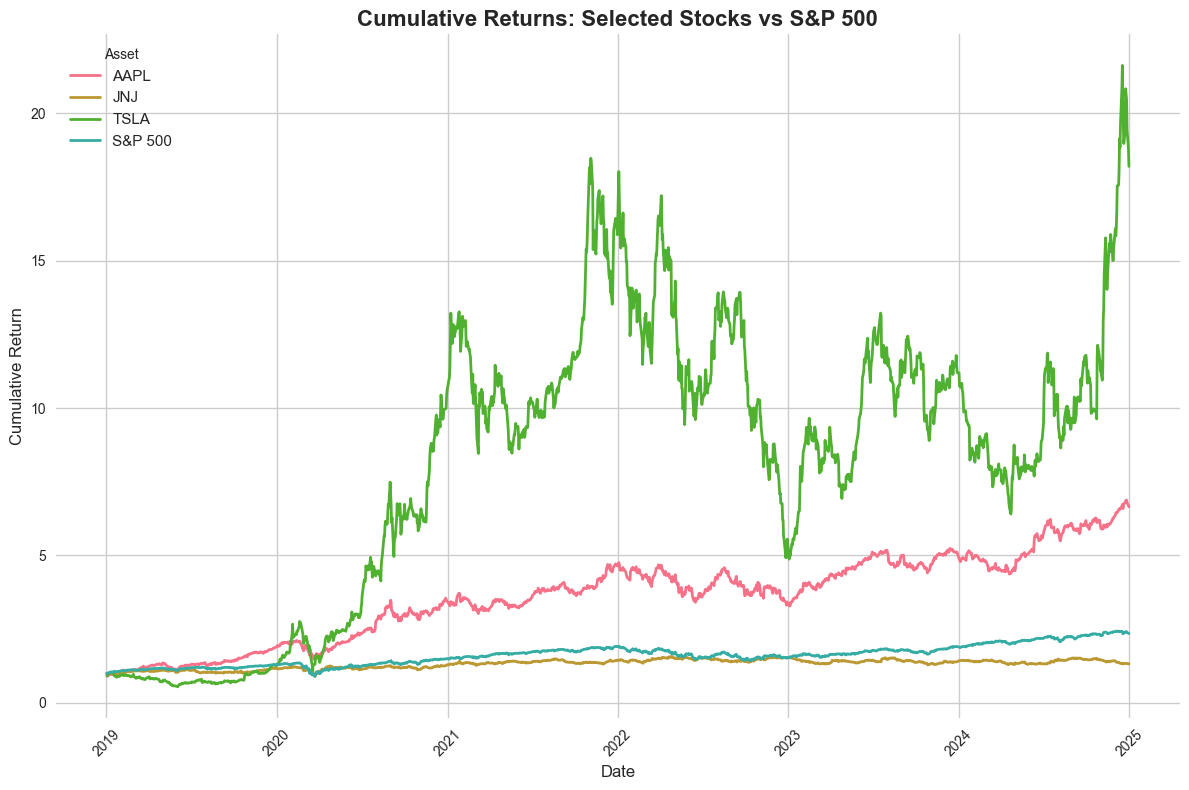

In [18]:
# Plot 2: Seaborn - Cumulative Returns with better styling
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.set_palette("husl")

# Prepare data for seaborn
plot_data = []
for ticker in selected_stocks:
    ticker_data = stock_cumret[stock_cumret['ticker'] == ticker][['dlycaldt', 'cumret']]
    ticker_data['ticker'] = ticker
    plot_data.append(ticker_data)

# Add market data
market_plot_data = market_cumret[['dlycaldt', 'cumret']].copy()
market_plot_data['ticker'] = 'S&P 500'
plot_data.append(market_plot_data)

plot_df = pd.concat(plot_data, ignore_index=True)

sns.lineplot(data=plot_df, x='dlycaldt', y='cumret', hue='ticker', 
             linewidth=2, markers=True, markersize=4)

plt.title('Cumulative Returns: Selected Stocks vs S&P 500', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(title='Asset', fontsize=11)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Plot 3: Plotly Express - Interactive Cumulative Returns

Finally, let's create an interactive plot using Plotly Express for enhanced user experience.

In [19]:
# Plot 3: Plotly Express - Interactive Cumulative Returns
fig = px.line(plot_df, x='dlycaldt', y='cumret', color='ticker',
              title='Interactive Cumulative Returns Comparison',
              labels={'dlycaldt': 'Date', 'cumret': 'Cumulative Return', 'ticker': 'Asset'},
              line_shape='linear', render_mode='svg')

fig.update_layout(
    title_font_size=16,
    xaxis_title_font_size=12,
    yaxis_title_font_size=12,
    legend_title_font_size=12,
    hovermode='x unified'
)

fig.show()

## Dividend Analysis

Now let's analyze dividends to understand the income component of our selected stocks.

In [20]:
# Now let's analyze dividends
print("\n=== Dividend Analysis ===")


=== Dividend Analysis ===


In [21]:
def calculate_cumulative_dividends(data):
    """Calculate cumulative dividends for each stock"""
    data = data.copy()
    data = data.sort_values(['ticker', 'dlycaldt'])
    
    # Handle potential duplicate dates by taking the last observation for each ticker-date combination
    data = data.drop_duplicates(subset=['ticker', 'dlycaldt'], keep='last')
    
    # Sum up all dividend amounts (ordinary + non-ordinary)
    data['total_div'] = data['dlyorddivamt'].fillna(0) + data['dlynonorddivamt'].fillna(0)
    
    # Calculate cumulative dividends using a safer approach
    data['cumdiv'] = 0.0  # Initialize with 0
    
    for ticker in data['ticker'].unique():
        mask = data['ticker'] == ticker
        dividends = data.loc[mask, 'total_div']
        cumulative = dividends.cumsum()
        data.loc[mask, 'cumdiv'] = cumulative
    
    return data

In [22]:
# Calculate cumulative dividends
stock_cumdiv = calculate_cumulative_dividends(selected_data)

# Get dividend summary
div_summary = stock_cumdiv.groupby('ticker').agg({
    'total_div': ['sum', 'count'],
    'cumdiv': 'max'
}).round(4)

div_summary.columns = ['total_dividends', 'dividend_days', 'cumulative_dividends']
print(div_summary)

        total_dividends  dividend_days  cumulative_dividends
ticker                                                      
AAPL               9.37           1510                  9.37
JNJ               25.98           1510                 25.98
TSLA                0.0           1510                  0.00


## Plot 4: Matplotlib - Cumulative Dividends

Let's visualize the cumulative dividends using matplotlib.

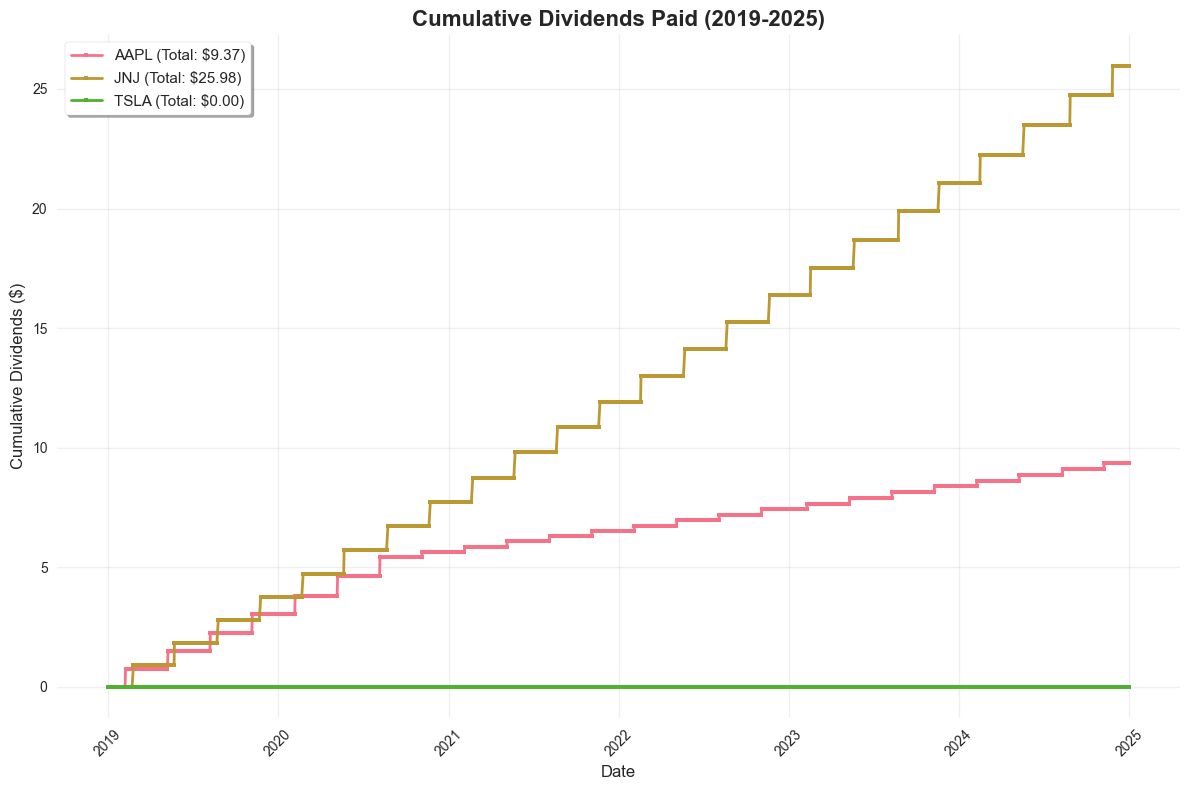

In [23]:
# Plot 4: Matplotlib - Cumulative Dividends
plt.figure(figsize=(12, 8))

for ticker in selected_stocks:
    ticker_data = stock_cumdiv[stock_cumdiv['ticker'] == ticker]
    plt.plot(ticker_data['dlycaldt'], ticker_data['cumdiv'], 
             label=f'{ticker} (Total: ${ticker_data["cumdiv"].max():.2f})', 
             linewidth=2, marker='s', markersize=3)

plt.title('Cumulative Dividends Paid (2019-2025)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Dividends ($)', fontsize=12)
plt.legend(fontsize=11, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Plot 5: Seaborn - Dividend Comparison

Now let's use Seaborn for the dividend visualization.

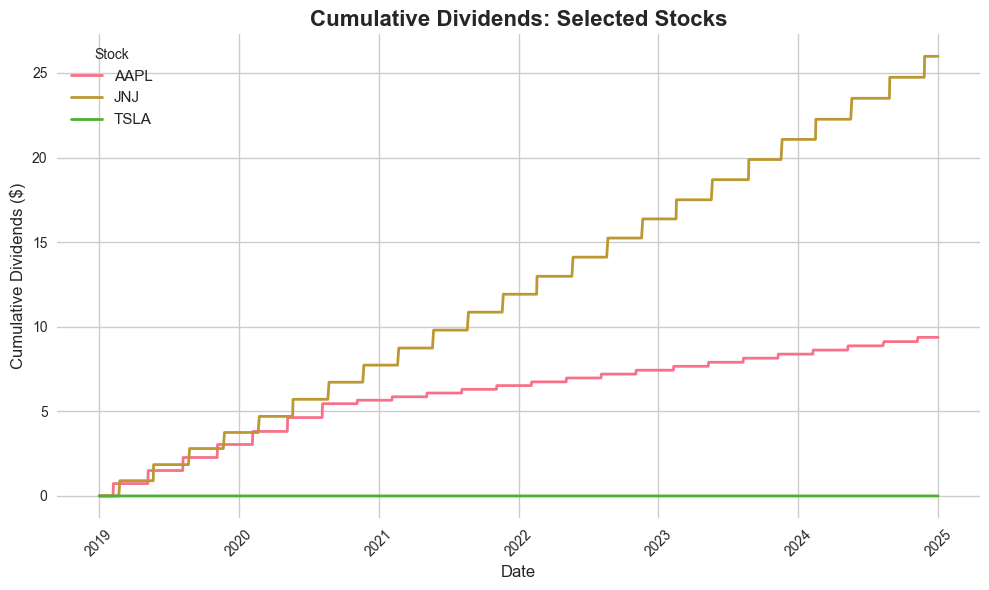

In [24]:
# Plot 5: Seaborn - Dividend Comparison
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Prepare dividend data for seaborn
div_plot_data = []
for ticker in selected_stocks:
    ticker_data = stock_cumdiv[stock_cumdiv['ticker'] == ticker][['dlycaldt', 'cumdiv']]
    ticker_data['ticker'] = ticker
    div_plot_data.append(ticker_data)

div_plot_df = pd.concat(div_plot_data, ignore_index=True)

sns.lineplot(data=div_plot_df, x='dlycaldt', y='cumdiv', hue='ticker', 
             linewidth=2, markers=True, markersize=4)

plt.title('Cumulative Dividends: Selected Stocks', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Dividends ($)', fontsize=12)
plt.legend(title='Stock', fontsize=11)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Plot 6: Plotly Express - Interactive Dividends

Let's create an interactive dividend plot with Plotly.

In [25]:
# Plot 6: Plotly Express - Interactive Dividends
fig = px.line(div_plot_df, x='dlycaldt', y='cumdiv', color='ticker',
              title='Interactive Cumulative Dividends',
              labels={'dlycaldt': 'Date', 'cumdiv': 'Cumulative Dividends ($)', 'ticker': 'Stock'},
              line_shape='linear', render_mode='svg')

fig.update_layout(
    title_font_size=16,
    xaxis_title_font_size=12,
    yaxis_title_font_size=12,
    legend_title_font_size=12,
    hovermode='x unified'
)

fig.show()

## Rolling Volatility Analysis

Now let's analyze the rolling volatility of our selected stocks to understand their risk characteristics over time.

In [26]:
# Now let's calculate rolling volatility (3-month window)
print("\n=== Rolling Volatility Analysis ===")


=== Rolling Volatility Analysis ===


In [27]:
def calculate_rolling_volatility(data, window_days=63):  # ~3 months (63 trading days)
    """Calculate rolling volatility for each stock"""
    data = data.copy()
    data = data.sort_values(['ticker', 'dlycaldt'])
    
    # Handle potential duplicate dates by taking the last observation for each ticker-date combination
    data = data.drop_duplicates(subset=['ticker', 'dlycaldt'], keep='last')
    
    # Calculate rolling standard deviation of returns using a safer approach
    data['rolling_vol'] = np.nan
    data['rolling_vol_annual'] = np.nan
    
    for ticker in data['ticker'].unique():
        mask = data['ticker'] == ticker
        returns = data.loc[mask, 'dlyret'].fillna(0)
        
        # Calculate rolling standard deviation
        rolling_std = returns.rolling(window=window_days, min_periods=30).std()
        data.loc[mask, 'rolling_vol'] = rolling_std
        
        # Annualize volatility (multiply by sqrt(252) for daily data)
        data.loc[mask, 'rolling_vol_annual'] = rolling_std * np.sqrt(252)
    
    return data

In [28]:
# Calculate rolling volatility for stocks
stock_vol = calculate_rolling_volatility(selected_data)

# Calculate rolling volatility for market
market_vol = market_data.copy()
market_vol['rolling_vol'] = market_vol['sprtrn'].rolling(
    window=63, min_periods=30
).std()
market_vol['rolling_vol_annual'] = market_vol['rolling_vol'] * np.sqrt(252)

## Plot 7: Matplotlib - Rolling Volatility

Let's visualize the rolling volatility using matplotlib.

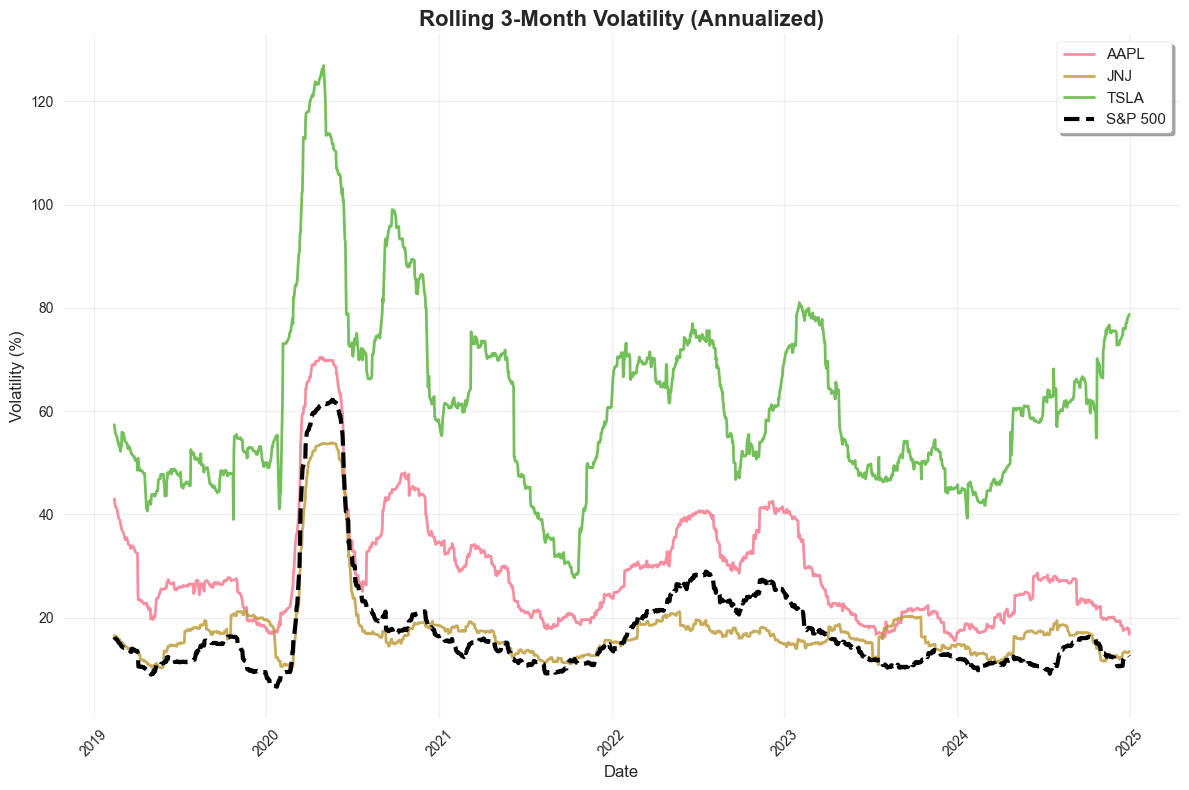

In [29]:
# Plot 7: Matplotlib - Rolling Volatility
plt.figure(figsize=(12, 8))

for ticker in selected_stocks:
    ticker_data = stock_vol[stock_vol['ticker'] == ticker]
    plt.plot(ticker_data['dlycaldt'], ticker_data['rolling_vol_annual'] * 100, 
             label=ticker, linewidth=2, alpha=0.8)

# Add market volatility
plt.plot(market_vol['dlycaldt'], market_vol['rolling_vol_annual'] * 100, 
         label='S&P 500', linewidth=3, color='black', linestyle='--')

plt.title('Rolling 3-Month Volatility (Annualized)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.legend(fontsize=11, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Plot 8: Seaborn - Volatility Comparison

Now let's use Seaborn for the volatility visualization.

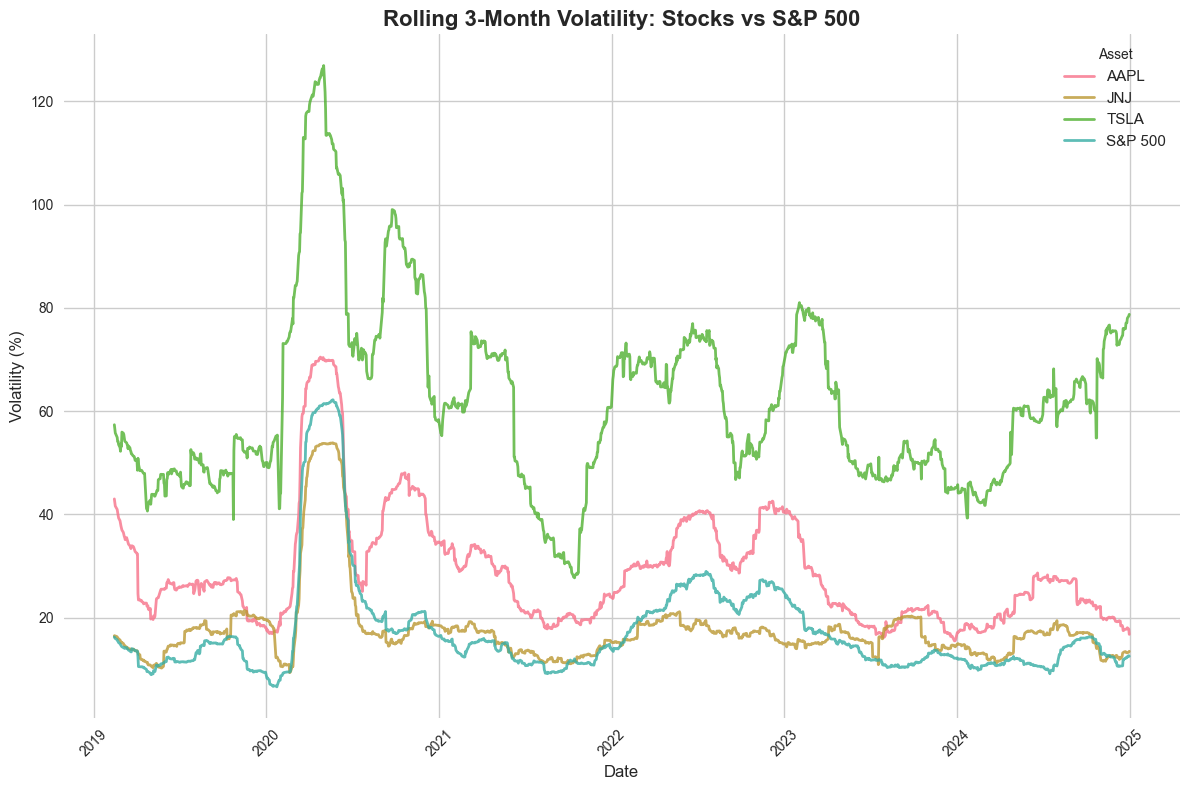

In [30]:
# Plot 8: Seaborn - Volatility Comparison
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Prepare volatility data for seaborn
vol_plot_data = []
for ticker in selected_stocks:
    ticker_data = stock_vol[stock_vol['ticker'] == ticker][['dlycaldt', 'rolling_vol_annual']]
    ticker_data['ticker'] = ticker
    vol_plot_data.append(ticker_data)

# Add market volatility
market_vol_data = market_vol[['dlycaldt', 'rolling_vol_annual']].copy()
market_vol_data['ticker'] = 'S&P 500'
vol_plot_data.append(market_vol_data)

vol_plot_df = pd.concat(vol_plot_data, ignore_index=True)
vol_plot_df['rolling_vol_annual'] = vol_plot_df['rolling_vol_annual'] * 100  # Convert to percentage

sns.lineplot(data=vol_plot_df, x='dlycaldt', y='rolling_vol_annual', hue='ticker', 
             linewidth=2, alpha=0.8)

plt.title('Rolling 3-Month Volatility: Stocks vs S&P 500', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.legend(title='Asset', fontsize=11)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Plot 9: Plotly Express - Interactive Volatility

Finally, let's create an interactive volatility plot with Plotly.

In [31]:
# Plot 9: Plotly Express - Interactive Volatility
fig = px.line(vol_plot_df, x='dlycaldt', y='rolling_vol_annual', color='ticker',
              title='Interactive Rolling Volatility Analysis',
              labels={'dlycaldt': 'Date', 'rolling_vol_annual': 'Volatility (%)', 'ticker': 'Asset'},
              line_shape='linear', render_mode='svg')

fig.update_layout(
    title_font_size=16,
    xaxis_title_font_size=12,
    yaxis_title_font_size=12,
    legend_title_font_size=12,
    hovermode='x unified'
)

fig.show()

## Summary Statistics

Let's compile a comprehensive summary of our analysis results.

In [32]:
# Summary statistics
print("\n=== Summary Statistics ===")
print("Cumulative Returns (as of latest date):")
for ticker in selected_stocks:
    latest_ret = stock_cumret[stock_cumret['ticker'] == ticker]['cumret'].iloc[-1]
    print(f"{ticker}: {latest_ret:.2f}x")

latest_market_ret = market_cumret['cumret'].iloc[-1]
print(f"S&P 500: {latest_market_ret:.2f}x")

print("\nTotal Dividends Paid:")
for ticker in selected_stocks:
    total_div = stock_cumdiv[stock_cumdiv['ticker'] == ticker]['cumdiv'].iloc[-1]
    print(f"{ticker}: ${total_div:.2f}")

print("\nAverage Annualized Volatility (3-month rolling):")
for ticker in selected_stocks:
    avg_vol = stock_vol[stock_vol['ticker'] == ticker]['rolling_vol_annual'].mean() * 100
    print(f"{ticker}: {avg_vol:.1f}%")

avg_market_vol = market_vol['rolling_vol_annual'].mean() * 100
print(f"S&P 500: {avg_market_vol:.1f}%")


=== Summary Statistics ===
Cumulative Returns (as of latest date):
AAPL: 6.65x
JNJ: 1.32x
TSLA: 18.20x
S&P 500: 2.35x

Total Dividends Paid:
AAPL: $9.37
JNJ: $25.98
TSLA: $0.00

Average Annualized Volatility (3-month rolling):
AAPL: 29.0%
JNJ: 17.7%
TSLA: 61.6%
S&P 500: 17.5%


## Analysis Complete

This script demonstrates:
1. Matplotlib plotting with pyplot interface
2. Seaborn plotting with enhanced styling
3. Plotly Express for interactive visualizations
4. Cumulative return analysis for selected stocks vs S&P 500
5. Dividend analysis comparing dividend-paying vs non-dividend stocks
6. Rolling volatility analysis using 3-month windows

The analysis provides insights into:
- Performance comparison between different types of stocks
- Income generation through dividends
- Risk characteristics over time
- Interactive visualization capabilities for data exploration
"""

print("\n=== Analysis Complete ===")
print("This script demonstrates:")
print("1. Matplotlib plotting with pyplot interface")
print("2. Seaborn plotting with enhanced styling")
print("3. Plotly Express for interactive visualizations")
print("4. Cumulative return analysis for selected stocks vs S&P 500")
print("5. Dividend analysis comparing dividend-paying vs non-dividend stocks")
print("6. Rolling volatility analysis using 3-month windows")